In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [44]:
%run dataset.py
%run config.py
%run __init__.py
%run grad_cam.py

<Figure size 640x480 with 0 Axes>

In [3]:
train_dataset = PneumoniaDetectionDataset(split="train")
val_dataset = PneumoniaDetectionDataset(split="val")
test_dataset = PneumoniaDetectionDataset(split="test")

In [4]:
classes = train_dataset.dataset.classes

In [5]:
sample_data = None
for data in test_dataset:
    sample_data = data
    break

In [6]:
sample_image, sample_label, _ = sample_data

In [7]:
eval_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=True,
)

In [8]:
pretrained_path = "trained/adam-0.0001-64-3-augment/epoch_2/"
model = torch.load(f"{pretrained_path}model.pth", weights_only=False)

In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [10]:
input_tensor = sample_image.unsqueeze(0)
targets = [ClassifierOutputTarget(0)]

In [ ]:
# with GradCAM(model=model, target_layers=[model.model[0].model.layer4[-1]]) as cam:
#   # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#   grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
#   # In this example grayscale_cam has only one image in the batch:
#   grayscale_cam = grayscale_cam[0, :]
#   visualization = show_cam_on_image(image.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
#   # You can also get the model outputs without having to redo inference
#   model_outputs = cam.outputs

In [11]:
for param in model.parameters():
    param.requires_grad = True

In [12]:
cam = GradCAM(model=model, target_layers=[model.model[0].model.layer4[-1]])
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(sample_image.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)

In [15]:
outputs = cam.outputs

In [53]:
torch.argmax(outputs, dim=1)[0]

tensor(0)

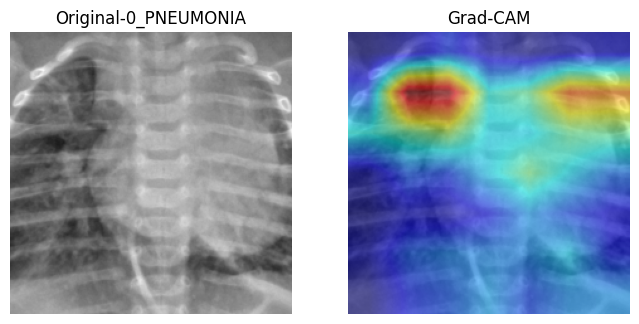

In [13]:
# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"Original-{classes[sample_label]}")
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(visualization)
plt.axis("off")
plt.show()

In [34]:
def save_grad_cam(model, image, label, save_dir):
    
    with GradCAM(model=model, target_layers=[model.model[0].model.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(sample_image.permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
        outputs = cam.outputs
        
        pred = torch.argmax(outputs, dim=1)[0]
        title = ""
        if pred == label:
            if label == 0:
                title = "Correct-Pneumonia"
            else:
                title = "Correct-Normal"
        else:
            if label == 0:
                title = "Incorrect-False-Negative"
            else:
                title = "Incorrect-False-Positive"

        
        # Plot
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis("off")
        
        plt.subplot(1,2,2)
        plt.imshow(visualization)
        plt.axis("off")
        # plt.show()
        plt.suptitle(title)
        os.makedirs(save_dir, exist_ok=True)
        # plt.savefig(f"{save_dir}/{title}.png")

In [45]:
save_grad_cam(model, sample_image, sample_label, "grad-cam/correct-pneumonia")
save_grad_cam(model, sample_image, sample_label, "grad-cam/correct-pneumonia")

In [39]:
import time

In [41]:
time.time()

1758073594.8891578

In [46]:
a = torch.zeros(5)

In [48]:
b = torch.ones(5)

In [51]:
for i, [num1, num2] in enumerate(zip(a, b)):
    print(num1.item() == 0, num2.item())

True 1.0
True 1.0
True 1.0
True 1.0
True 1.0
